# The GPS Problem

This notebook is part of [Bite Size Bayes](https://allendowney.github.io/BiteSizeBayes/), an introduction to probability and Bayesian statistics using Python.

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

The following cell downloads `utils.py`, which contains some utility function we'll need.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/BiteSizeBayes/raw/master/utils.py')

If everything we need is installed, the following cell should run with no error messages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Fixing GPS

The Global Positioning System (GPS) is widely used satellite-based navigation system.  If you have a GPS receiver, you can use it to estimate your position on earth in three dimensions: latitude, longitude, and altitude.

Although GPS is accurate enough for applications like getting driving directions, is is subject to errors from several sources, [described in this Wikipedia article](https://en.wikipedia.org/wiki/Error_analysis_for_the_Global_Positioning_System).

For purposes of this problem, I'll assume that the distribution of errors in the horizontal directions is a normal distribution with mean 0 and standard deviation 5 m.  I'll also assume that errors in the $x$ and $y$ directions are independent.

In other words, if you stand on a survey marker placed by the [National Geodetic Survey (NGS)](https://en.wikipedia.org/wiki/U.S._National_Geodetic_Survey), so that your position is known with high accuracy, and take a single reading from a GPS receiver, the difference between the reading and the actual position would be well-modeled by a normal distribution.

SciPy provides an object called `norm` we can use to represent a normal distribution with a given mean and standard deviation.

In [3]:
from scipy.stats import norm

error_dist = norm(0, 5)

`norm` provides a function called `pdf` that compute the Probability Density Function (PDF) of the distribution.

In [4]:
xs = np.linspace(-15, 15)
ps = error_dist.pdf(xs)

In [5]:
error_series = pd.Series(ps, index=xs)

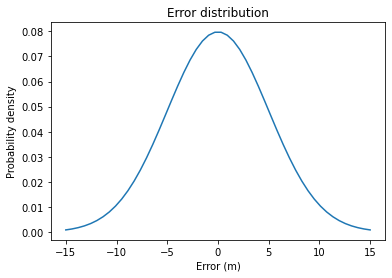

In [6]:
error_series.plot()
plt.xlabel('Error (m)')
plt.ylabel('Probability density')
plt.title('Error distribution');

In [7]:
def outer_product(s1, s2):
    """Compute the outer product of two Series.
    
    First Series goes down the rows;
    second goes across the columns.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    a = np.multiply.outer(s1.to_numpy(), s2.to_numpy())
    return pd.DataFrame(a, index=s1.index, columns=s2.index)

Here's what the distributions of width look like.

In [8]:
joint_dist = outer_product(error_series, error_series)

In [9]:
def plot_contour(joint):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    plt.contour(joint.index, joint.index, joint)
    plt.ylabel('y position in m')
    plt.xlabel('x position in m')

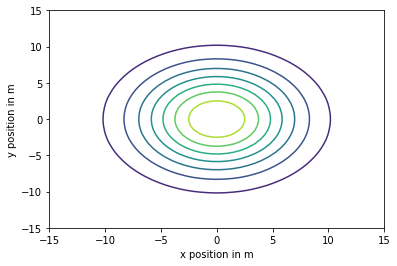

In [10]:
plot_contour(joint_dist)

## Inferring position

Now suppose I am standing in a field with a survey marker at the center.  I'll define the position of the marker to be the origin, where `x` and `y` positions are `0`, and I'll define east to be the positive `x` axis and north to be the positive `y` axis.

I don't know my actual location, but based on a single GPS reading, I compute that I am 10 m east and 20 m north of the marker.

Based on this reading, what is the posterior distribution of my actual location?

Well, it depends on how I got there.

To get started, let's assume that I am equally likely to be at any location in a large, square field.  In that case, `x` and `y` are independent and their distributions are uniform.

In [11]:
def make_pmf(xs, ps, **options):
    """Make a Series that represents a PMF.
    
    xs: sequence of values
    ps: sequence of probabilities
    options: keyword arguments passed to Series constructor
    
    returns: Pandas Series
    """
    pmf = pd.Series(ps, index=xs, **options)
    pmf /= pmf.sum()
    return pmf

In [12]:
xs = np.linspace(-50, 50, 101)
prior_x = make_pmf(xs, 1)

In [13]:
ys = np.linspace(-50, 50, 101)
prior_y = make_pmf(ys, 1)

I'll group the data by species and compute summary statistics.

To compute the likelihood of the `x` data, we can ask, "If my actual position were `x`, what is the probability my GPS reading would be 10 m?"

To answer that question, we can compute the hypothetical error for each value of `x`:

In [14]:
error_x = 10 - xs

Then we can use `error_dist` to compute the probability of the hypothetical errors.

In [15]:
likelihood = error_dist.pdf(error_x)

And the posterior distribution.

In [16]:
posterior_x = prior_x * likelihood
posterior_x /= posterior_x.sum()

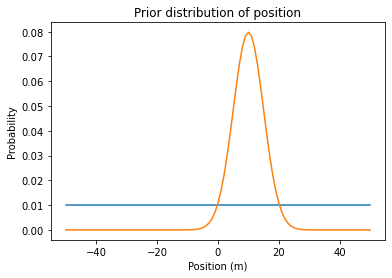

In [17]:
prior_x.plot(label='prior')
posterior_x.plot(label='posterior')

plt.xlabel('Position (m)')
plt.ylabel('Probability')
plt.title('Prior distribution of position');

In [18]:
error_y = 20 - ys

likelihood = error_dist.pdf(error_y)

posterior_y = prior_y * likelihood
posterior_y /= posterior_y.sum()

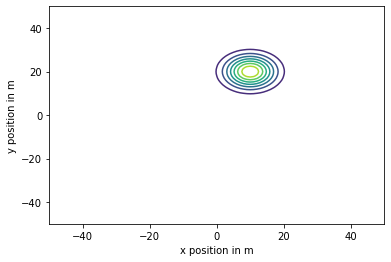

In [19]:
joint_posterior1 = outer_product(posterior_y, posterior_x)
plot_contour(joint_posterior1)

This result might not come as a surprise to you.  With a uniform prior, the posterior is just a normalized version of the likelihood function.

Since the likelihood function is the PDF of a normal distribution, the posterior is a normal distribution with mean at the measured location, (10, 20), and the same standard deviation as the error distribution.

So we could have figured that out in our heads.  But now that we have done it the hard way, we are ready to solve harder problems.

## Parachuting in

Suppose I parachute into the field and try to land on the marker, and suppose my actualy landing position is well modeled by a normal distribution, along both axes, with mean 0 and standard deviation 15 m.

We can construct the marginal distributions for my positions along the `x` and `y` axes, like this:

In [20]:
landing_dist = norm(0, 15)

In [21]:
xs = np.linspace(-50, 50, 101)
ps = landing_dist.pdf(xs)
prior_x = make_pmf(xs, ps)

In [22]:
ys = np.linspace(-50, 50, 101)
ps = landing_dist.pdf(ys)
prior_y = make_pmf(ys, ps)

Assuming that my errors along the two axes are independent, we can use `outer_product` to construct the joint distribution for my landing spot.

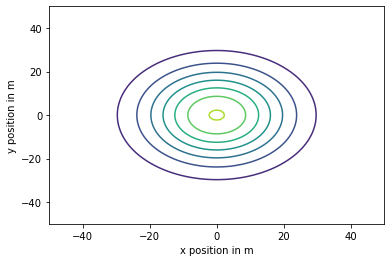

In [23]:
joint_posterior = outer_product(prior_y, prior_x)

plot_contour(joint_posterior)

After landing, suppose I take a single GPS reading that indicates I am 10 m east and 20 m north of the marker.

I can use the GPS reading to update the distribution of my `x` coordinate, exactly as in the previous problem.

In [24]:
error_x = 10 - xs

likelihood = error_dist.pdf(error_x)

posterior_x = prior_x * likelihood
posterior_x /= posterior_x.sum()

Here's what the prior and posterior distributions look like for my `x` coordinate:

prior_x.plot(label='prior')
posterior_x.plot(label='posterior')

plt.xlabel('Position (m)')
plt.ylabel('Probability')
plt.title('Prior distribution of position')
plt.legend();

To compute the posterior mean, I'll use this function, which we've seen in a previous notebook.

In [25]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

The posterior mean is 9, a little less than the GPS reading, because in the prior distribution, values closer to 0 are more likely.

In [26]:
pmf_mean(posterior_x)

9.0

**Exercise:**  Update the `y` coordinate with the GPS read (20 m north) and compute the posterior mean.  We expect it to be a bit less than 20 m.

In [27]:
# Solution

error_y = 20 - ys

likelihood = error_dist.pdf(error_y)

posterior_y = prior_y * likelihood
posterior_y /= posterior_y.sum()

In [28]:
# Solution

pmf_mean(posterior_y)

17.999999999888672

In this version of the problem, the `x` and `y` coordinates are independent, so we can use `outer_product` to construct the joint posterior.

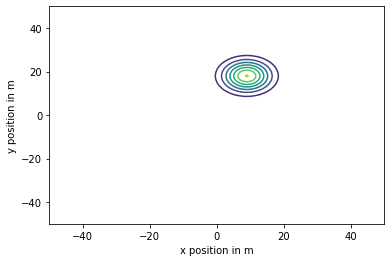

In [29]:
joint_posterior2 = outer_product(posterior_y, posterior_x)
plot_contour(joint_posterior2)

If you are not convinced that the coordinates are independent, just because I say say, you could update the joint prior distribution rather than the marginal distributions.  In the next example, we'll see how.

## Running away

Suppose I start out standing on the marker, spin until I am facing in a random direction, and then walk about 30 m, where my margin of error is 3 m.

So my distance from the origin is well modeled by a normal distribution with mean 30 and standard deviation 3.

Before I get a GPS reading, what is the prior distribution of my position?

In this example, `x` and `y` are not independent.  For example, if I know that `x` is near 30 m, that implies that `y` is near 0.  And if I know `y` is near 0, that implies that `x` is close to 30 m or -30 m.

To construct the prior distribution, I'll start with a joint distribution for `x` and `y` that is uniform and independent.  Then I'll do a Bayesian update with the data that I am 15 from the origin.

Here are the uniform marginal priors we've used before.

In [30]:
xs = np.linspace(-50, 50, 101)
prior_x = make_pmf(xs, 1)

In [31]:
ys = np.linspace(-50, 50, 101)
prior_y = make_pmf(ys, 1)

And here is the uniform joint prior.

In [32]:
joint_prior = outer_product(prior_x, prior_y)

To compute the distances from the center, I'll use the `outer` version of the NumPy function `hypot`, which computes the hypotenuse of a triangle with the given sides.

See how useful outer function are?

In [33]:
distances = np.hypot.outer(xs, ys)
distances.shape

(101, 101)

Now, to compute a likelihood function, we can compute `error`, which is the difference between each hypothetical distance and the data, which is 30 m.

In [34]:
error = distances - 30
error.shape

(101, 101)

The distribution of these errors is normal with standard deviation 3 m.

In [35]:
error_dist = norm(0, 3)

To get the likelihoods, we evaluate the normal PDF for each hypothetical error.

In [36]:
likelihood = error_dist.pdf(error)
likelihood.shape

(101, 101)

As usual, the posterior distribution is the normalize product of the prior and the likelihood.

In [37]:
joint_posterior3 = joint_prior * likelihood
joint_posterior3 /= joint_posterior3.to_numpy().sum()

And here's what the posterior joint distribution looks like.

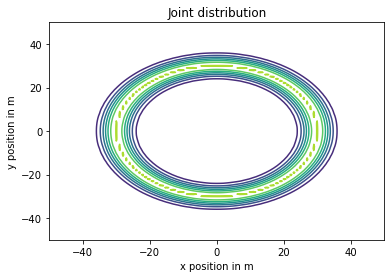

In [38]:
plot_contour(joint_posterior3)

plt.title('Joint distribution');

Remember that we did all that to compute the prior before we get a GPS reading.

Now suppose we take a reading and it indicates that we are 10 m east and 20 m north of the marker (as in the previous versions).

We'll use the posterior we just computed as the prior for the next update.

In [39]:
donut_prior = joint_posterior3

To compute the likelihoods, I'm going to cheat a little.

Remember that in the first version of the problem we started with a uniform prior and did an update with the same data.  The posterior we computed is just the normalized likelihood of the data, so we can use it as the likelihood for this update.

In [40]:
likelihood = joint_posterior1

As usual, the posterior is the normalized product of the prior and the likelihood.

In [41]:
donut_posterior = donut_prior * likelihood
donut_posterior /= donut_posterior.to_numpy().sum()

And here's what it looks like.

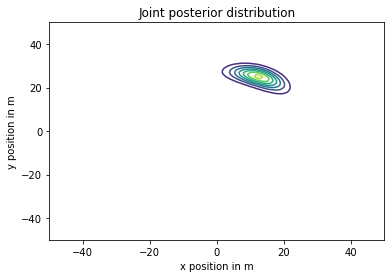

In [42]:
plot_contour(donut_posterior)

plt.title('Joint posterior distribution');

It reminds me of [The Bean](https://en.wikipedia.org/wiki/Cloud_Gate).

## Marginal posterior distributions

From the joint posterior distribution we can extract the marginal distributions for the coordinates.

In [43]:
def marginal(joint, axis):
    """Compute a marginal distribution.
    
    axis=0 returns the marginal distribution of the second variable
    axis=1 returns the marginal distribution of the first variable
    
    joint: DataFrame representing a joint PMF
    axis: int axis to sum along
    
    returns: Series representing a marginal PMF
    """
    return joint.sum(axis=axis)

In [44]:
donut_posterior_x = marginal(donut_posterior, 0)
donut_posterior_y = marginal(donut_posterior, 1)

Here's what they look like.

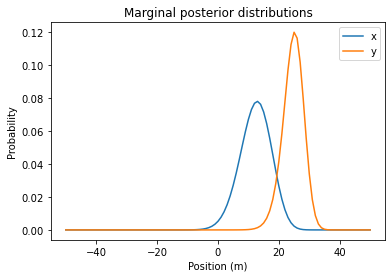

In [45]:
donut_posterior_x.plot(label='x')
donut_posterior_y.plot(label='y')

plt.xlabel('Position (m)')
plt.ylabel('Probability')
plt.title('Marginal posterior distributions')
plt.legend();

And here are the posterior means.

In [46]:
mean_x = pmf_mean(donut_posterior_x)
mean_x

12.312006344725674

In [47]:
mean_y = pmf_mean(donut_posterior_y)
mean_y

24.62401268945136

Here's the distance from the marker to the location of the posterior means:

In [48]:
np.hypot(mean_x, mean_y)

27.530483126215326

This distance represents a compromise between two sources of information: 

* I started with the prior belief that I was 30 m from the marker, but

* My GPS reading suggests that I am only about 22 m from the marker.

In [49]:
np.hypot(10, 20)

22.360679774997898

The posterior mean distance is close to 30 m than 22 m because the margin of error in the prior, 3 m, is less than the margin of error of GPS, which is 5 m in each direction.

In [50]:
np.hypot(5, 5)

7.0710678118654755

In this case, Bayes's theorem tells us that we should give more weight to out prior belief about the distance.

Actually, the posterior mean distance we just computed is not quite right because we computed the means of the marginal distributions independently.

To compute the posterior mean correctly, we have to compute the weighted sum of the hypothetical distances, using the posterior probabilities as weights.

In [51]:
qs = distances
ps = donut_posterior.values

np.sum(qs * ps)

28.095352174426047

## Summary
